In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv

In [2]:
filename = './videos/gray/news.avi'

In [3]:
def diff_pixels(frameA, frameB, params):
    diff = np.abs(frameA - frameB)
    return np.where(diff > params[0], 1, 0).sum()


In [4]:
def diff_blocks(frameA, frameB, params):
    diff = np.abs(frameA - frameB)
    diff = diff * diff

    count = 0
    for row in range(0, frameA.shape[0], params[0]):
        for col in range(0, frameA.shape[1], params[0]):
            root = np.sqrt(diff[row:row+params[0], col:col+params[0]].sum())
            if root > params[1]:
                count += 1

    return count


In [5]:
def get_metrics(file, difference, params, dtype='int16'):
    cap = cv.VideoCapture(file)

    metrics = []

    ret, frame = cap.read()

    old_frame = frame[:, :, 0].astype(dtype)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            gray_frame = frame[:, :, 0].astype(dtype)
            metrics.append(difference(gray_frame, old_frame, params))
            old_frame = gray_frame
        else:
            cap.release()
            break

    return metrics


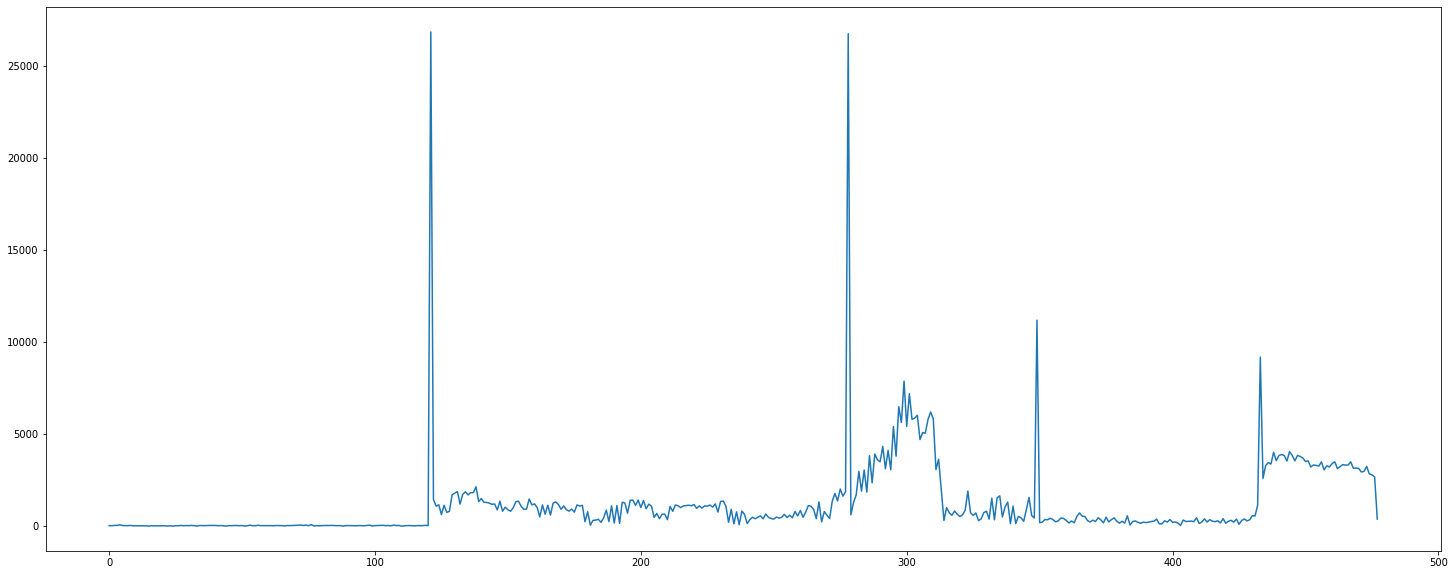

In [6]:
Y = np.array(get_metrics(filename, diff_pixels, [128]))
X = range(len(Y))

plt.figure(figsize=(25,10))
plt.plot(X, Y)

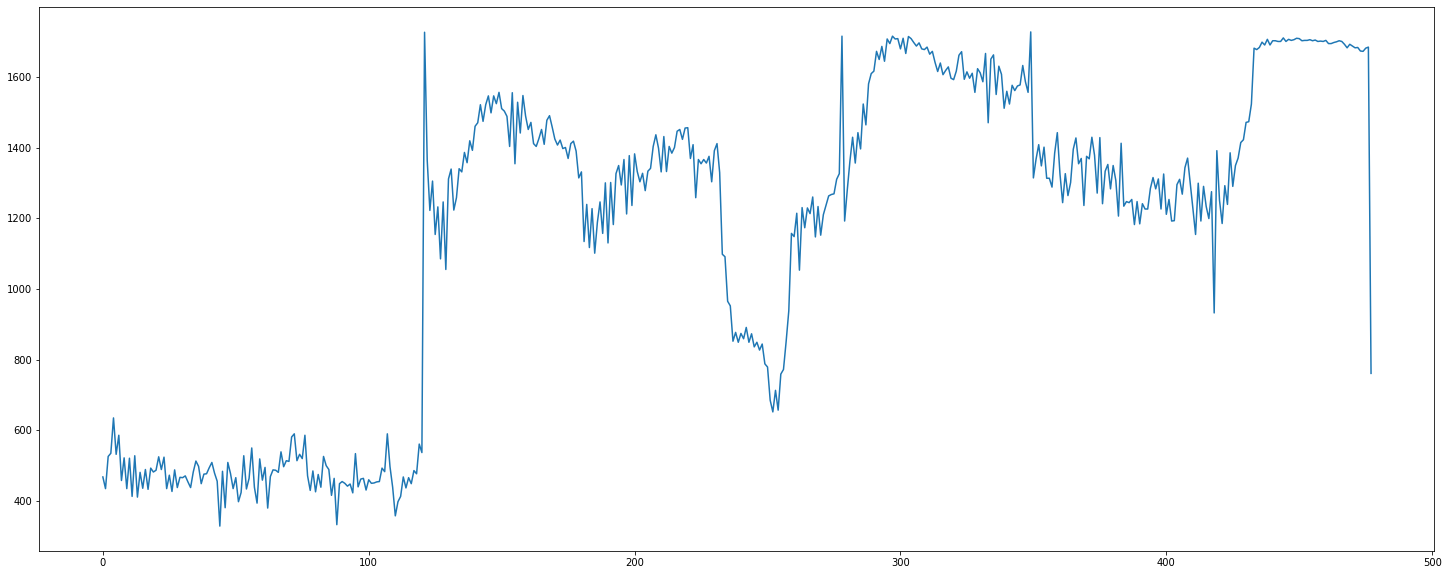

In [7]:
Y = np.array(get_metrics(filename,diff_blocks, [8, 64, 128], 'int32'))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)